/home/FYP/varsha006/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tc1apps/2_conda_env/CZ4042_v5/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/tc1apps/2_conda_env/CZ4042_v5/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-04-11 03:55:11.788293: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computa

Training RoBERTa CNN model...
Epoch 1/10
Train Loss: 0.3431, Train Acc: 0.8804
Val Loss: 0.1416, Val Acc: 0.9520
Epoch 2/10
Train Loss: 0.1730, Train Acc: 0.9527
Val Loss: 0.1333, Val Acc: 0.9553
Epoch 3/10
Train Loss: 0.1362, Train Acc: 0.9606
Val Loss: 0.1189, Val Acc: 0.9593
Epoch 4/10
Train Loss: 0.1041, Train Acc: 0.9708
Val Loss: 0.1558, Val Acc: 0.9497
Epoch 5/10
Train Loss: 0.0794, Train Acc: 0.9767
Val Loss: 0.1536, Val Acc: 0.9533
Epoch 6/10
Train Loss: 0.0778, Train Acc: 0.9786
Val Loss: 0.1272, Val Acc: 0.9629
Epoch 7/10
Train Loss: 0.0539, Train Acc: 0.9843
Val Loss: 0.2148, Val Acc: 0.9451
Epoch 8/10
Train Loss: 0.0588, Train Acc: 0.9823
Val Loss: 0.1564, Val Acc: 0.9593
Epoch 9/10
Train Loss: 0.0482, Train Acc: 0.9857
Val Loss: 0.1612, Val Acc: 0.9635
Epoch 10/10
Train Loss: 0.0373, Train Acc: 0.9889
Val Loss: 0.1698, Val Acc: 0.9547
Test Loss: 0.3706, Test Acc: 0.9303
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     

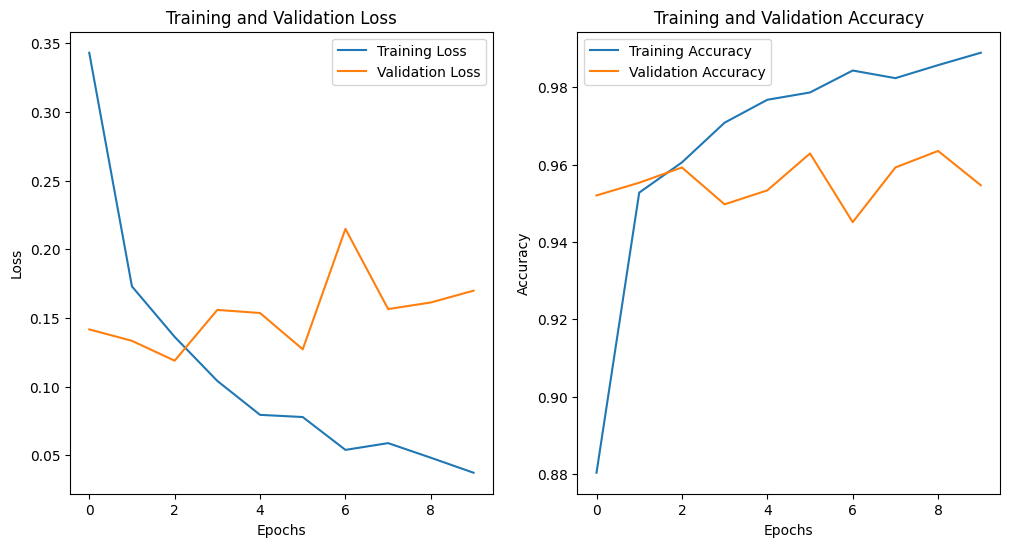

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data Processing
# Reading in dataset
df_train = pd.read_json('emo-train.json')
df_test = pd.read_json('emo-test.json')
df_train = df_train.drop(df_train[df_train['Label']=='others'].index)
df_test = df_test.drop(df_test[df_test['Label']=='others'].index)

# Encoding labels
label_encoder = LabelEncoder()
df_train['Label'] = label_encoder.fit_transform(df_train['Label'])
df_test['Label'] = label_encoder.transform(df_test['Label'])

# Create PyTorch Dataset
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create train, validation, and test datasets
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Create datasets
train_dataset = EmotionDataset(
    texts=train_df['text'].values,
    labels=train_df['Label'].values,
    tokenizer=tokenizer
)

val_dataset = EmotionDataset(
    texts=val_df['text'].values,
    labels=val_df['Label'].values,
    tokenizer=tokenizer
)

test_dataset = EmotionDataset(
    texts=df_test['text'].values,
    labels=df_test['Label'].values,
    tokenizer=tokenizer
)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model Definition
class RobertaCNNClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout=0.5):
        super(RobertaCNNClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.conv1d = nn.Conv1d(in_channels=768, out_channels=32, kernel_size=2)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(32, num_classes)
        
    def forward(self, input_ids, attention_mask):
        # Get RoBERTa embeddings
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Permute for conv1d which expects [batch_size, channels, seq_len]
        x = last_hidden_state.permute(0, 2, 1)  # [batch_size, hidden_size, seq_len]
        
        # Apply CNN
        x = self.conv1d(x)  # [batch_size, 32, seq_len-1]
        x = torch.relu(x)
        
        # Global max pooling
        x = self.global_max_pool(x).squeeze(-1)  # [batch_size, 32]
        
        # Apply dropout and classification layer
        x = self.dropout(x)
        logits = self.classifier(x)
        
        return logits

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label_encoder.classes_)
model = RobertaCNNClassifier(num_classes=num_classes)
model = model.to(device)

# Set up training parameters
num_epochs = 10
learning_rate = 2e-5

# Use class weights to handle imbalanced data
class_counts = np.bincount(train_df['Label'])
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training function
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        
        total_loss += loss.item() * input_ids.size(0)
        total_correct += correct
        total_samples += input_ids.size(0)
    
    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            
            total_loss += loss.item() * input_ids.size(0)
            total_correct += correct
            total_samples += input_ids.size(0)
    
    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples
    return epoch_loss, epoch_acc

# Training loop
print('Training RoBERTa CNN model...')
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Detailed classification report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save the model
torch.save(model.state_dict(), 'roberta_cnn_model.pt')